In this tutorial we will demostrateWe will use GWAS summary of Ulcerative Colitis as an example in this tutorial.

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
try:
    import cPickle as pickle
except:
    import pickle
    
import sqlite3
import sys
sys.path.append(os.path.abspath('../')) ## set up path to the gwas component package
import gwas_component.gwas_component as gc

In [2]:
phenotype  = 'IBD.EUR.Ulcerative_Colitis'
tissue = u'Colon_Transverse'
tissue0 = tissue.replace('-', '_')

First we read pre-computed S-predixcan results from SQL database. The data can be downloaded from [here](https://github.com/hakyimlab/MetaXcan). What we want from this file is the gene-level association of Ulcerative Colitis. We will construct a dictionary gene2z that maps a gene id to its z-score. 

In [3]:
connection = sqlite3.connect("metaxcan_results_p/metaxcan_results_v1.5.db")

query = 'SELECT g.gene_name, m.zscore, m.n_snps_used, m.n_snps_model, p.tag as phenotype, t.tissue as tissue, g.gene ' 
query += ' FROM gene AS g INNER JOIN metaxcan_result AS m ON g.id = m.gene_id' 
query += ' INNER JOIN tissue AS t ON t.id = m.tissue_id  INNER JOIN pheno AS p ON p.id = m.pheno_id'
query += ' WHERE p.tag = \'%s\'' % phenotype

pi = pd.read_sql_query(query, connection)
item0 = pi[pi.tissue == tissue]   
    
gene2z = {g:z for g, z in zip(item0.gene, item0.zscore)}  

The z-scores of a few genes are shown below.

In [4]:
for i, (g, z) in enumerate(gene2z.items()):
    print('gene_id: %s, z-score: % .5f' % (g, z))
    if i > 5: break

gene_id: ENSG00000247077, z-score:  1.06393
gene_id: ENSG00000106003, z-score: -0.28316
gene_id: ENSG00000157833, z-score: -0.57141
gene_id: ENSG00000171403, z-score: -2.12226
gene_id: ENSG00000189298, z-score: -0.49704
gene_id: ENSG00000103051, z-score: -0.74893
gene_id: ENSG00000059377, z-score:  0.19078


Now we can setup and run the gwas component model. We first need to initial a tissue specific gwas component model using gc.Coexpression_Model(tissue). Then run the function compute_z to compute the association of co-expression gene modules.

In [5]:
gc_model = gc.Coexpression_Model(tissue0)
gc_model.compute_z(gene2z) 

(array([ 1.87155317e+00,  2.46192777e+00,  3.69317015e+00,  1.90382305e+00,
         3.78801416e-01, -1.76478160e+00, -7.24276802e-01, -1.98131665e+00,
         4.81201523e-01, -8.60540855e-01, -1.58552758e+00, -8.75857506e-01,
        -1.28961538e+00,  1.97099125e+00,  9.23610787e-01, -1.06994271e+00,
        -9.25884838e-01,  1.13467880e+00, -2.78176606e+00, -1.23242756e+00,
        -1.95225971e+00, -3.52487815e-01, -3.98758069e+00, -9.88091934e-01,
        -1.93583357e-01, -1.30077413e+00,  1.50603823e-01,  1.03500257e-01,
        -8.33065890e-01,  1.66297752e+00, -1.03232033e+00, -6.38897289e-02,
         1.59691686e+00, -6.19436744e-01, -7.14247959e-01,  3.92126695e-01,
         4.96871625e-01, -2.15521318e-02,  5.21693818e-01,  1.67212945e-01,
        -3.42873261e-01,  2.14403712e+00,  1.50302000e+00, -1.44245170e+00,
        -4.49944235e-01, -9.38089954e-01, -2.00822833e-01, -4.56777419e-01,
        -1.26716554e-01,  3.56529454e+00,  1.23180003e+00, -1.36005534e+00,
         3.8

The following figure shows all z-scores of co-expression modules. We can see there are at least two modules with z-score > 10.

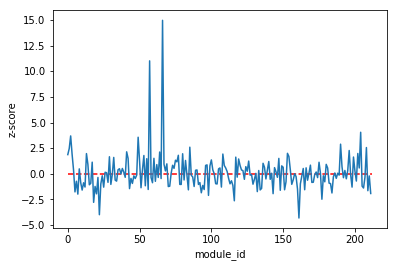

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(gc_model.res_z)
plt.hlines(0, 0, len(gc_model.res_z), 'r', linestyles='dashed')
plt.xlabel('module_id')
plt.ylabel('z-score')

plt.show()

We can also inspect what genes are involved in these co-expression modules. The get_associated_components() will return such information.

In [7]:
out = pd.DataFrame([(m0, g) for m0, gs in gc_model.get_associated_components() for g in gs])
out.columns = ['coexpression_module', 'gene_id']
out

,coexpression_module,gene_id
0,indianred,ENSG00000116586
1,indianred,ENSG00000129158
2,indianred,ENSG00000111671
3,indianred,ENSG00000010626
4,indianred,ENSG00000176473
5,indianred,ENSG00000103599
6,indianred,ENSG00000205309
7,indianred,ENSG00000188878
8,indianred,ENSG00000204920
9,indianred,ENSG00000185608


We can also use the function get_driver_genes() to see if there are any drivers detected from these gene modules.

In [8]:
drgenes = gc_model.get_driver_genes()

out = pd.DataFrame([item[1] for item in drgenes])
out.columns = ['gene_id', 'oddratio', 'pval', 'adj_pval']
out

,gene_id,oddratio,pval,adj_pval
0,ENSG00000143674,11.077586,0.000660,0.047669
1,ENSG00000130413,25.531250,0.000699,0.049797
2,ENSG00000172818,25.531250,0.000699,0.049797
3,ENSG00000117399,25.531250,0.000699,0.049797
4,ENSG00000102554,25.531250,0.000699,0.049797
